# Lab4: Gradient Blending


This project explores gradient-domain processing, a simple technique with a broad set of applications including blending, tone-mapping, and non-photorealistic rendering. This specific project explores seamless image compositing via "Poisson blending".

The primary goal of this assignment is to seamlessly blend an object or texture from a source image into a target image. The simplest method would be to just copy and paste the pixels from one image directly into the other (and this is eactly what the starter code does). Unfortunately, this will create very noticeable seams, even if the backgrounds are similar. How can we get rid of these seams without doing too much perceptual damage to the source region?

The insight is that people are more sensitive to gradients than absolute image intensities. So we can set up the problem as finding values for the output pixels that maximally preserve the gradient of the source region without changing any of the background pixels. Note that we are making a deliberate decision here to ignore the overall intensity! We will add an object into an image by reintegrating from (modified) gradients and forgetting whatever absolute intensity it started at.

## Simple 1d Examples

Let's start with a simple case where instead of copying in new gradients we only want to fill in a missing region of an image and keep the gradients as smooth (close to zero) as possible. To simplify things further, let's start with a one dimensional signal instead of a two dimensional image. 

Here is our signal t and a mask M specifying which "pixels" are missing.

![Alt](doc_images/1_labeled.png "Title")

```python
t = [5 4 0 0 0 0 2 4];
M = [0 0 1 1 1 1 0 0];
M = logical(M);
```

We can formulate our objective as a least squares problem. Given the intensity values of t, we want to solve for new intensity values v under the mask M such that 

![Alt](doc_images/eqn_1.png "Title")

Here i is a coordinate (1d or 2d) for each pixel under mask M. Each j is a neighbor of i. Each summation guides the gradient (the local pixel differences) in all directions to be close to 0. In the first summation, the gradient is between two unknown pixels, and the second summation handles the border situation where one pixel is unknown and one pixel is known (outside the mask M). Minimizing this equation could be called a Poisson fill. 

For this example let's define neighborhood to be the pixel to your left (you could define neighborhood to be all surrounding pixels. In 2d, you would at least need to consider vertical and horizontal neighbors). The least squares solution to the following system of equations satisfies the formula above.

```python
v(1) - t(2) = 0; %left border
v(2) - v(1) = 0;
v(3) - v(2) = 0;
v(4) - v(3) = 0;
t(7) - v(4) = 0; %right border
```

Note that the coordinates don't directly correspond between v and t — v(1), the first unknown pixel, sits on top of t(3). You could formulate it differently if you choose. Plugging in known values of t we get

```python
v(1) -    4 = 0;
v(2) - v(1) = 0;
v(3) - v(2) = 0;
v(4) - v(3) = 0;
   2 - v(4) = 0;
```

Now let's convert this to matrix form and solve it

```python
A = [ 1  0  0  0; ...
     -1  1  0  0; ...
      0 -1  1  0; ...
      0  0 -1  1; ...
      0  0  0 -1];
  
b = [4; 0; 0; 0; -2];
  
```

![Alt](doc_images/2_labeled.png "Title")

As it turns out, in the 1d case, the Poisson fill is simply a linear interpolation between the boundary values. But in 2d the Poisson fill exhibits more complexity. Now instead of just doing a fill, let's try to seamlessly blend content from one 1d signal into another. We'll fill the missing values in t using the correspondig values in s:

```python
s = [5 6 7 2 4 5 7 3];
```

![Alt](doc_images/3_labeled.png "Title")

Now our objective changes — instead of trying to minimize the gradients, we want the gradients to match another set of gradients (those in s). We can write this as follows:

![Alt](doc_images/eqn_2.png "Title")


We minimize this by finding the least squares solution to this system of equations:
```python
v(1) - t(2) = s(3) - s(2);
v(2) - v(1) = s(4) - s(3);
v(3) - v(2) = s(5) - s(4);
v(4) - v(3) = s(6) - s(5);
t(7) - v(4) = s(7) - s(6);
```

After plugging in known values from t and s this becomes:
```python
v(1) -    4 =  1;
v(2) - v(1) = -5;
v(3) - v(2) =  2;
v(4) - v(3) =  1;
   2 - v(4) =  2;
```
Finally, in matrix form for Matlab
```python
A = [ 1  0  0  0; ...  
     -1  1  0  0; ...
      0 -1  1  0; ...
      0  0 -1  1; ...
      0  0  0 -1];
  
b = [5; -5; 2; 1; 0];
  
If we solve Ax=b and combine the values of x with t, we get:

```
![Alt](doc_images/4_labeled.png "Title")


## Task 1: 1D Blending (10)

Simply implement the example above and plot the results for linear interpolation and using the gradients from S. Note that the matrix A is the same!!

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

[False False  True  True  True  True False False]
(array([ 3.6,  3.2,  2.8,  2.4]), array([ 0.8]), 4, array([ 1.90211303,  1.61803399,  1.1755705 ,  0.61803399]))
[ 5.   4.   3.6  3.2  2.8  2.4  2.   4. ]


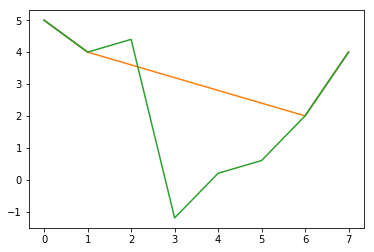

In [15]:
%matplotlib inline
from pylab import *
import numpy as np
import scipy

t = np.array([5., 4., 0., 0., 0., 0., 2., 4.])
mask = np.array([1, 1, 0, 0, 0, 0, 1, 1])
plot(zero_to_nan(t))

reverseMask = np.array([1 if x==0 else 0 for x in mask])
reverseMask = reverseMask.astype(bool);
print(reverseMask)

## -------------------------------------

A = [[ 1.,  0.,  0.,  0.],
     [-1.,  1.,  0.,  0.],
     [ 0., -1.,  1.,  0.],
     [ 0.,  0., -1.,  1.],
     [ 0.,  0.,  0., -1.]]

b = [4, 0, 0, 0, -2]

## -------------------------------------

solution = np.linalg.lstsq(A,b)
print(solution)
tmp = np.insert(solution[0], 0, [0,0])
tmp = np.insert(tmp, 6, [0,0])
print(tmp + t)

## -------------------------------------

poisson_filling = [ 5.,   4.,   3.6,  3.2,  2.8, 2.4,  2.,   4. ]
plot (poisson_filling) 
gradient_composite = [ 5.,   4.,   4.4, -1.2,  0.2,  0.6,  2.,   4. ]
plot (gradient_composite) 

In [ ]:
def someMath(arr):
    mask = np.array([0 if x==0 else 1 for x in arr])
    reverseMask = np.array([1 if x==0 else 0 for x in mask])

## Poisson reconstruction in 2D

Notice that in our quest to preserve gradients without regard for intensity we might have gone too far — our signal now has negative values. The same thing can happen in the image domain, so you'll want to watch for that and at the very least clamp values back to the valid range. When working with images, the basic idea is the same as above, except that each pixel has at least two neighbors (left and top) and possibly four neighbors. Either formulation will work. 

For example, in a 2d image using a 4-connected neighborhood, our equations above imply that for a single pixel in v, at coordinate (i,j) which is fully under the mask you would have the following equations:

```python
v(i,j) - v(i-1, j) = s(i,j) - s(i-1, j)
v(i,j) - v(i+1, j) = s(i,j) - s(i+1, j)
v(i,j) - v(i, j-1) = s(i,j) - s(i, j-1)
v(i,j) - v(i, j+1) = s(i,j) - s(i, j+1)
```

In this case we have many equations for each unknown. It may be simpler to combine these equations such that there is one equation for each pixel, as this can make the mapping between rows in your matrix A and pixels in your images easier. Adding the four equations above we get:
```python
4*v(i,j) - v(i-1, j) - v(i+1, j) - v(i, j-1) - v(i, j+1) = 4*s(i,j) - s(i-1, j) - s(i+1, j) - s(i, j-1) - s(i, j+1)
```

Note that the right hand of this equation is known and coincides with the discrete Laplacian that we computed in previous labs!




## Task 2: 2D Poisson Reconstruction (20)

!BE AWARE! This will be slow...

For this task we will take a simple image, compute it's laplacian and reconstruct from this laplacian the original image. This will be very slow, so only use it for the small test image. 

* For color images, process each color channel independently (hint: matrix A won't change, so don't go through the computational expense of rebuilding it for each color channel).



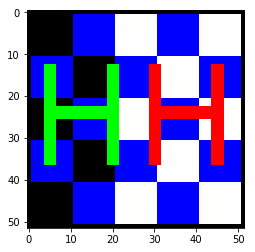

In [81]:
%matplotlib inline
from pylab import *

import imageio as imio
import numpy as np
import scipy.ndimage as nd
import scipy.sparse

im = nd.imread("data/test.png")[:,:,:3]/255.

def Laplacian(im):
    laplacian_kernel = np.array([[ 0, -1,  0], 
                                 [-1,  4, -1], 
                                 [ 0, -1,  0]]) 
    
    #{‘reflect’,’constant’,’nearest’,’mirror’, ‘wrap’}
    conv =  nd.convolve(im, laplacian_kernel,mode='constant')    
    return conv

def add_border(im):
    border_im = np.zeros((im.shape[0]+2,im.shape[1]+2,im.shape[2]))
    border_im[1:-1,1:-1] = im
    return border_im


def buildSystemNaive(im_shape):
    size = np.prod(im_shape)
    A = np.identity(size) * 4
    #complete the values of A
    
    for i in range(size):
        if (i+1 < size):
            A[i+1,i] = -1
        if (i-1 >= 0):
            A[i-1,i] = -1
        if (i+im_shape[1] < size):
            A[i+im_shape[1],i] = -1
        if (i-im_shape[1] >= 0):
            A[i-im_shape[1],i] = -1
    
    #print(A[:im_shape[0]+3, :im_shape[0]+3])
    return A

im = add_border(im)

#this is done once for all three channels
A = buildSystemNaive(im[:,:,0].shape)

b = Laplacian(im[:,:,0])
red = np.linalg.lstsq(A, b.ravel())[0]
red = np.clip( red.reshape(b.shape), 0.0, 1.0 )

b = Laplacian(im[:,:,1])
green = np.linalg.lstsq(A, b.ravel())[0]
green = np.clip( green.reshape(b.shape), 0.0, 1.0 )

b = Laplacian(im[:,:,2])
blue = np.linalg.lstsq(A, b.ravel())[0]
blue = np.clip( blue.reshape(b.shape), 0.0, 1.0 )
#repeat this for all channels...

result =np.dstack((red,green,blue))
#result =np.dstack((red,red,red))

#The result should be the original image
imshow(result)

## Task 3: 2D Poisson Reconstruction Sparse (30)

The linear system of equations (and thus the matrix A) becomes enormous. But A is also very sparse because each equation only relates a pixel to some number of its immediate neighbors.

A needs at least as many rows and columns as there are pixels in the masked region (in our example the hole image).

If the mask covers 100,000 pixels, this implies a matrix with at least 100,000,000,000 entries. Don't try that. 

So we will use sparse matrix and a least squares solver for sparse matrices. You can use whatever matrix format you want for indexing, but when returning A, transform it to one of the compressed formats, A = A.tocsr() or A.tocsc(), that improves the performance of the solvers by a lot.

I tested scipy sparse. https://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html

You have lmrs and lmqr but they are quite slow. The iterative solvers are much faster. http://www.scipy-lectures.org/advanced/scipy_sparse/solvers.html Any of them should give you a fair performance. In my case the congugate gradient seemed to be the fastest.

You can try with a bigger image now. Do not forget to add the border so the image is properly reconstructed.

Now building the matrix A is probably the slowest part of the process if you did it with loops. 
You can use %%time at the beginning of the cell to measure its time of execution


(162, 295)
CPU times: user 8.22 s, sys: 122 ms, total: 8.34 s
Wall time: 2.75 s


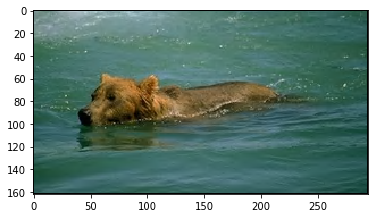

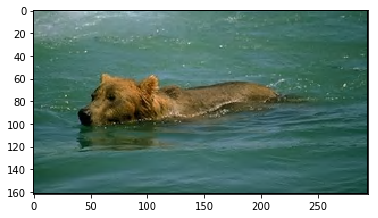

In [77]:
%%time
# %env OMP_NUM_THREADS=20
%matplotlib inline
from pylab import *

import numpy as np
import scipy.ndimage as nd
import scipy.sparse as sp

# im = nd.imread("data/test.png")[:,:,:3]/255.
im = nd.imread("data/bear2.png")[:,:,:3]/255.

def Laplacian(im):
    laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])    
    #{‘reflect’,’constant’,’nearest’,’mirror’, ‘wrap’}
    conv =  nd.convolve(im, laplacian_kernel,mode='constant')    
    return conv

def add_border(im):
    border_im = np.zeros((im.shape[0]+2,im.shape[1]+2,im.shape[2]))
    border_im[1:-1,1:-1] = im
    return border_im

im = add_border(im)
imshow(im)
plt.figure()

def buildSystemSparse(im_shape):
    size = np.prod(im_shape)
    print(im_shape)
    A = sp.lil_matrix((size,size))
    
    A.setdiag(4)
    A.setdiag(-1, 1)
    A.setdiag(-1,-1)
    A.setdiag(-1, im_shape[1])
    A.setdiag(-1,-im_shape[1])
    
#     print(A)
    return A.tocsr() #A.tocsc()

A = buildSystemSparse(im[:,:,0].shape)

b = Laplacian(im[:,:,0])
# red = sp.linalg.spsolve(A, b.ravel())
red = sp.linalg.cgs(A, b.ravel())[0]
red = np.clip( red.reshape(b.shape), 0.0, 1.0 )

b = Laplacian(im[:,:,1])
# green = sp.linalg.spsolve(A, b.ravel())
green = sp.linalg.cgs(A, b.ravel())[0]
green = np.clip( green.reshape(b.shape), 0.0, 1.0 )

b = Laplacian(im[:,:,2])
# blue = sp.linalg.spsolve(A, b.ravel())
blue = sp.linalg.cgs(A, b.ravel())[0]
blue = np.clip( blue.reshape(b.shape), 0.0, 1.0 )
#repeat this for all channels...

result =np.dstack((red,green,blue))

#The result should be the original image
imshow(result)

## Task 4: 2D Poisson Compositing (40)

This formulation is similar to equation 8 in [Pérez, et al.](http://cs.brown.edu/courses/cs129/asgn/proj2/resources/PoissonImageEditing.pdf)  You can read more of that paper, especially the "Discrete Poisson Solver", if you want more guidance. 

Esssentially you need to build A and b so it takes care of the boundary conditions using the mask. You can do it when you iterate to create the matrix A, or you can operate with the mask and the Laplacian to do it directly on with the images. In the second case, you probably have problems if your mask or composite does not have a border.

The test data has a standard easy boundary, you don't even have to move the image in order to do the composite. 
The equations (A and b) for the pixels inside the pasted image (fg) will be the same as before, however the pixels at the boundary change. 

If we look at the equation in Task 1 for 2D image

4*v(i,j) - v(i-1, j) - v(i+1, j) - v(i, j-1) - v(i, j+1) = 4*s(i,j) - s(i-1, j) - s(i+1, j) - s(i, j-1) - s(i, j+1)

Now some of the neighbours in the left side (unkowns) are actually know (values from the background image at the boundary. So these values need to be added to the right side. 

When constructing A, you also want to have the mask into account, so you only have equations for the values that you want to compute. In convenience you can create the matrix of the size of the mask and leave the rows for the pixels not interested to 0. Of course also for the values of b. 

For this task you can do a clean solution ignoring special cases of boundaries as follow.

Pasted | Poisson
- | - 
![Alt](data/pasted.png) | ![Alt](data/composite.png)


HINT: You can do this using the mask (and its inverse) and the laplacian operator with the fg and bg



(160, 293)
(46880, 46880)
done
CPU times: user 3.13 s, sys: 89 ms, total: 3.22 s
Wall time: 1.09 s


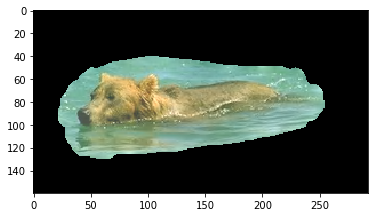

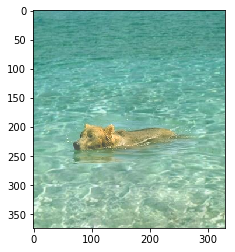

In [84]:
%%time
%matplotlib inline
from pylab import *

import imageio as imio
import numpy as np
import scipy.ndimage as nd
import scipy.sparse

mask = imio.imread("data/bear2_mask.png")[:,:,1]/255
mask_inv = 1.-mask
fg =imio.imread("data/bear2.png")[:,:,:3]/255.
bg =imio.imread("data/waterpool.png")[:,:,:3]/255.

# imshow(mask)
# plt.figure()
# imshow(mask_inv)
# plt.figure()
# imshow(fg)
# plt.figure()
# imshow(bg)

off = [140,30]

# bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]] = bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]]*dstack((mask,mask,mask))+ fg*dstack((mask_inv,mask_inv,mask_inv))

# imshow(bg)
# imio.imwrite("data/pasted.png",bg)

def buildNewSystemSparse(im_shape, mask):
    size = np.prod(im_shape)
    print(im_shape)
    A = sp.lil_matrix((size,size))
    
    for i in range(size):
        y,x = divmod(i,im_shape[1])
        if mask[y,x]:
            A[i,i] = 4
            if mask[y,x+1] and (i+1 < size):
                A[i+1,i] = -1
            if mask[y,x-1] and (i-1 >= 0):
                A[i-1,i] = -1
            if mask[y+1,x] and (i+im_shape[1] < size):
                A[i+im_shape[1],i] = -1
            if mask[y-1,x] and (i-im_shape[1] >= 0):
                A[i-im_shape[1],i] = -1
    
#     print(A)
    return A.tocsr() #A.tocsc()

A = buildNewSystemSparse(fg[:,:,0].shape, mask_inv)

print(A.shape)

bg_tmp = bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]]


b_add = mask[:,:,np.newaxis] * bg_tmp
b_add = Laplacian(b_add[:,:,0]) * mask_inv
# plt.figure(); imshow(b_add); 

b = -b_add +  Laplacian(fg[:,:,0]) 
b = b * mask_inv
# # red = sp.linalg.spsolve(A, b.ravel())
red = sp.linalg.isolve.cgs(A, b.ravel())[0]
red = np.clip( red.reshape(b.shape), 0.0, 1.0 )

# ------------------------------------------------------

b_add = mask[:,:,np.newaxis] * bg_tmp
b_add = Laplacian(b_add[:,:,1]) * mask_inv

b = -b_add +  Laplacian(fg[:,:,1]) 
b = b * mask_inv
# green = sp.linalg.spsolve(A, b.ravel())
green = sp.linalg.cgs(A, b.ravel())[0]
green = np.clip( green.reshape(b.shape), 0.0, 1.0 )

# ------------------------------------------------------

b_add = mask[:,:,np.newaxis] * bg_tmp
b_add = Laplacian(b_add[:,:,2]) * mask_inv

b = -b_add +  Laplacian(fg[:,:,2]) 
b = b * mask_inv
# blue = sp.linalg.spsolve(A, b.ravel())
blue = sp.linalg.cgs(A, b.ravel())[0]
blue = np.clip( blue.reshape(b.shape), 0.0, 1.0 )
#repeat this for all channels...

result =np.dstack((red,green,blue))

#The result should be the original image
plt.figure(); imshow(result)
print("done")

fg = result
bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]] = bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]]*dstack((mask,mask,mask))+ fg*dstack((mask_inv,mask_inv,mask_inv))

plt.figure(); imshow(bg)


## Extras : Improve compositing and test other images

Allow for moving the composite on other places and with your images, paste several things... This is easy to do, maybe tedious, but the results can be really fun.



## Extras : Other editings with gradients.

Gradient editing is very powerful, in the [paper](http://cs.brown.edu/courses/cs129/asgn/proj2/resources/PoissonImageEditing.pdf) you have some examples. Some ideas...

* Mixing Gradients to allow transparent images or images with holes. Instead of trying to adhere to the gradients of the source image, at each masked pixel use the largest gradient available in either the source or target. You can also try taking the average of gradients in the source and target.

* Color2Gray: Sometimes, in converting a color image to grayscale (e.g., when printing to a laser printer), we lose the important contrast information, making the image difficult to understand. For example, compare the color version of the image on right with its grayscale version produced by rgb2gray(). Can you do better than rgb2gray? Gradient-domain processing provides one avenue: create a gray image that has similar intensity to the rgb2gray output but has similar contrast to the original RGB image. This is an example of a tone-mapping problem, conceptually similar to that of converting HDR images to RGB displays. To get credit for this, show the grayscale image that you produce (the numbers should be easily readable). Hint: Try converting the image to HSV space and looking at the gradients in each channel. Then, approach it as a mixed gradients problem where you also want to preserve the grayscale intensity. 

Color | Gray
- | - 
![Alt](doc_images/colorBlindTest35.png) | ![Alt](doc_images/colorBlindTest35_gray.png)

 
 
* Automatically shifting the offset of the source image to decrease the difference of the images in the composite area.
* Implement and compare other blending techniques, such as Laplacian pyramid blending.
* Perform the blending on video frames instead of still images.
* Try other applications of gradient domain editing such as non-photorealistic rendering, edge enhancement, and texture transfer.


This Lab is an adaptation of this one http://cs.brown.edu/courses/cs129/asgn/proj2/